In [287]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import string
from nltk.corpus import stopwords
import preprocessor as p
from text_preprocessing import preprocess_text
from text_preprocessing import to_lower, expand_contraction, remove_number, remove_punctuation, remove_whitespace, normalize_unicode, lemmatize_word, remove_stopword
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_selection import SelectKBest, chi2
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report, f1_score
import sklearn.utils
import sys
import regex as re
import itertools
import emoji
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation
from tensorflow.keras.layers import Embedding, SpatialDropout1D
from tensorflow.keras.layers import Input, LSTM, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical, plot_model
from sklearn.utils import shuffle
import pickle
from joblib import dump, load
from sklearn.model_selection import GridSearchCV

In [288]:
hate = pd.read_csv("/Volumes/DATA/UNIMI/Text Mining and Sentiment Analysis/labeled.csv", sep=',')

In [289]:
hate.head(5)

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [290]:
drop_cols = ["count", "hate_speech", "offensive_language", "neither", "Unnamed: 0"]
df = hate.drop(drop_cols, axis = 1)

Text(0, 0.5, 'Counts')

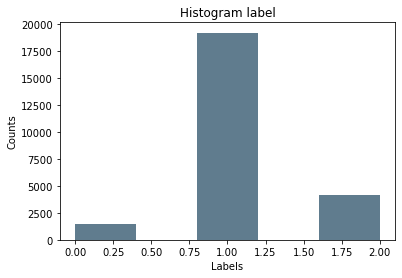

In [291]:
#Plotting histogram of labels to see how they are distributed
df['class'].plot.hist(bins=5, rwidth=2, color='#607c8e')
plt.title('Histogram label')
plt.xlabel('Labels')
plt.ylabel('Counts')

## Dealing with imbalenced dataset
Trying to add more data

In [292]:
hate2 = pd.read_csv("/Users/namnguyen/Downloads/hatespeech-master/data.csv", sep=',', encoding = "utf-8")

In [293]:
hate3 = pd.read_csv("/Users/namnguyen/Downloads/hatespeech-master/NAACL_SRW_2016.csv", sep=',')

In [294]:
hate2.shape

(16907, 3)

In [295]:
hate3

,tid,type
0,572342978255048705,racism
1,572341498827522049,racism
2,572340476503724032,racism
3,572334712804384768,racism
4,572332655397629952,racism
...,...,...
16902,576359685843861505,none
16903,576612926838046720,none
16904,576771329975664640,none
16905,560595245814267905,none


In [296]:
type(hate3['tid'][0])

numpy.int64

In [297]:
hate2

,tid,text,date;
0,572342978255048705,So Drasko just said he was impressed the girls...,2015-03-02 10:29:34;
1,572341498827522049,Drasko they didn't cook half a bird you idiot ...,2015-03-02 10:23:41;
2,572340476503724032,Hopefully someone cooks Drasko in the next ep ...,2015-03-02 10:19:37;
3,572334712804384768,of course you were born in serbia...you're as ...,2015-03-02 09:56:43;
4,572332655397629952,These girls are the equivalent of the irritati...,2015-03-02 09:48:33;
...,...,...,...
16902,576359685843861505,NaN,;
16903,576612926838046720,NaN,;
16904,576771329975664640,NaN,;
16905,560595245814267905,"@panelrific: Let's go 🐧🐧🐧🐧🐧🐧😃""""","2015-01-29 00:28:16"";"


In [298]:
hate2['tid'] = hate2['tid'].astype(int)

In [299]:
hate3 = hate3.drop_duplicates(subset='tid', keep="last")

In [300]:
hate3

,tid,type
3,572334712804384768,racism
4,572332655397629952,racism
6,551659627872415744,racism
7,551763146877452288,racism
8,551768543277355009,racism
...,...,...
16902,576359685843861505,none
16903,576612926838046720,none
16904,576771329975664640,none
16905,560595245814267905,none


In [301]:
hate2 = hate2.drop_duplicates(subset='tid', keep="last")

In [302]:
hate2

,tid,text,date;
3,572334712804384768,of course you were born in serbia...you're as ...,2015-03-02 09:56:43;
4,572332655397629952,These girls are the equivalent of the irritati...,2015-03-02 09:48:33;
6,551659627872415744,NaN,;
7,551763146877452288,NaN,;
8,551768543277355009,NaN,;
...,...,...,...
16902,576359685843861505,NaN,;
16903,576612926838046720,NaN,;
16904,576771329975664640,NaN,;
16905,560595245814267905,"@panelrific: Let's go 🐧🐧🐧🐧🐧🐧😃""""","2015-01-29 00:28:16"";"


In [303]:
hate_df = pd.merge(hate2, hate3, how='inner', on=['tid'])

In [304]:
hate_df

,tid,text,date;,type
0,572334712804384768,of course you were born in serbia...you're as ...,2015-03-02 09:56:43;,racism
1,572332655397629952,These girls are the equivalent of the irritati...,2015-03-02 09:48:33;,racism
2,551659627872415744,NaN,;,racism
3,551763146877452288,NaN,;,racism
4,551768543277355009,NaN,;,racism
...,...,...,...,...
16844,576359685843861505,NaN,;,none
16845,576612926838046720,NaN,;,none
16846,576771329975664640,NaN,;,none
16847,560595245814267905,"@panelrific: Let's go 🐧🐧🐧🐧🐧🐧😃""""","2015-01-29 00:28:16"";",none


In [305]:
hate_df = hate_df.dropna(axis='rows')

In [306]:
hate_speech = {
  0: "neither",
  1: "racism",
  2: "sexism"
}

In [307]:
type_encode = []
for x in hate_df['type']:
    if x == "racism":
        type_encode.append(1)
    if x == "sexism":
        type_encode.append(2)
    if x == "none":
        type_encode.append(0)

In [308]:
len(type_encode)

9802

In [309]:
hate_df['type'] = type_encode

/Users/namnguyen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [310]:
hate_df

,tid,text,date;,type
0,572334712804384768,of course you were born in serbia...you're as ...,2015-03-02 09:56:43;,1
1,572332655397629952,These girls are the equivalent of the irritati...,2015-03-02 09:48:33;,1
1932,446460991396917248,RT @YesYoureRacist: At least you're only a tin...,2014-03-20 01:39:29;,1
1933,489938636956135424,@MisfitInChains @oldgfatherclock @venereverita...,2014-07-18 01:04:08;,1
1934,502315096052596736,RT @Dreamdefenders: Eric Holder from #ferguson...,"2014-08-21 04:43:46"";",1
...,...,...,...,...
16765,576180808504848384,@ProoN ❤️,2015-03-13 00:39:44;,0
16766,576255143101882368,RT @Transition: @freebsdgirl just so I’m clear...,2015-03-13 05:35:07;,0
16768,576481461424934912,RT @Leonard_Delaney: @freebsdgirl I know! Holy...,2015-03-13 20:34:25;,0
16769,576607445692256256,FLOSS Weekly open source projects and paying t...,2015-03-14 04:55:02;,0


In [311]:
hate_df['tweet'] = hate_df['text']

/Users/namnguyen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [312]:
hate_df

,tid,text,date;,type,tweet
0,572334712804384768,of course you were born in serbia...you're as ...,2015-03-02 09:56:43;,1,of course you were born in serbia...you're as ...
1,572332655397629952,These girls are the equivalent of the irritati...,2015-03-02 09:48:33;,1,These girls are the equivalent of the irritati...
1932,446460991396917248,RT @YesYoureRacist: At least you're only a tin...,2014-03-20 01:39:29;,1,RT @YesYoureRacist: At least you're only a tin...
1933,489938636956135424,@MisfitInChains @oldgfatherclock @venereverita...,2014-07-18 01:04:08;,1,@MisfitInChains @oldgfatherclock @venereverita...
1934,502315096052596736,RT @Dreamdefenders: Eric Holder from #ferguson...,"2014-08-21 04:43:46"";",1,RT @Dreamdefenders: Eric Holder from #ferguson...
...,...,...,...,...,...
16765,576180808504848384,@ProoN ❤️,2015-03-13 00:39:44;,0,@ProoN ❤️
16766,576255143101882368,RT @Transition: @freebsdgirl just so I’m clear...,2015-03-13 05:35:07;,0,RT @Transition: @freebsdgirl just so I’m clear...
16768,576481461424934912,RT @Leonard_Delaney: @freebsdgirl I know! Holy...,2015-03-13 20:34:25;,0,RT @Leonard_Delaney: @freebsdgirl I know! Holy...
16769,576607445692256256,FLOSS Weekly open source projects and paying t...,2015-03-14 04:55:02;,0,FLOSS Weekly open source projects and paying t...


In [313]:
hate_df = hate_df.drop(['tid', 'text', 'date;'], axis = 1)

In [314]:
hate_df.columns = ['class', 'tweet']

In [315]:
hate_df = hate_df.append(df)

In [316]:
hate_df = hate_df.sample(frac=1)

In [317]:
hate_df

,class,tweet
9682,1,Hate on what bitch http://t.co/QzTnw6cdKi
13342,1,Niggas put on wigs and act like bitches for re...
19937,1,RT @rollieghost: &#8220;@vivalajayxoxo: Women ...
12250,0,@Crusina_Luachra but regardless i don't need t...
19643,1,RT @maya_hampton: @whateverduuude ily ur a bad...
...,...,...
15917,0,@nkilgore67 I'm sure you know all the slots ro...
8950,2,Enjoying the eccentricity of @RayEvernham's Am...
11545,0,@Nayadrikj OKAY I'M BACK
12791,1,Maybe you should eat makeup so you can be pret...


In [318]:
from sklearn.model_selection import train_test_split
X = hate_df['tweet']
y = hate_df['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

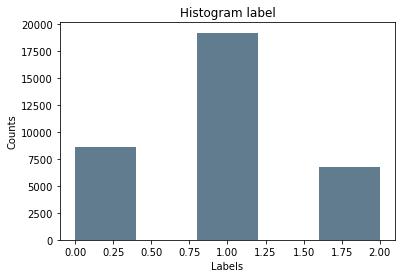

In [319]:
#Plotting histogram of labels to see how they are distributed
y.plot.hist(bins=5, rwidth=2,
                   color='#607c8e')
plt.title('Histogram label')
plt.xlabel('Labels')
plt.ylabel('Counts')
plt.savefig('label_distributed.png', dpi=200, transparent=True)

### Data cleaning

In [320]:
FLAGS = re.MULTILINE | re.DOTALL

def hashtag(text):
    text = text.group()
    hashtag_body = text[1:]
    if hashtag_body.isupper():
        result = " {} ".format(hashtag_body.lower())
    else:
        result = " ".join(["<hashtag>"] + re.split(r"(?=[A-Z])", hashtag_body, flags=FLAGS))
    return result

def tokenize(text):
    # Different regex parts for smiley faces
    eyes = r"[8:=;]"
    nose = r"['`\-]?"

    # function so code less repetitive
    def re_sub(pattern, repl):
        return re.sub(pattern, repl, text, flags=FLAGS)

    text = re_sub(r"https?:\/\/\S+\b|www\.(\w+\.)+\S*", "") #url
    #remove username
    #text = re_sub(r"@\w+", "<user>")
    text = re_sub(r"@\w+", " ")
    text = re_sub(r"{}{}[)dD]+|[)dD]+{}{}".format(eyes, nose, nose, eyes), "")
    text = re_sub(r"{}{}p+".format(eyes, nose), "") #lolface
    text = re_sub(r"{}{}\(+|\)+{}{}".format(eyes, nose, nose, eyes), "")
    text = re_sub(r"{}{}[\/|l*]".format(eyes, nose), "")
    text = re_sub(r"/"," / ")
    text = re_sub(r"<3","")
    text = re_sub(r"[-+]?[.\d]*[\d]+[:,.\d]*", "")
    #text = re_sub(r"#\S+", hashtag)
    text = re_sub(r"([!?.]){2,}", r"\1 <repeat>")
    text = re_sub(r"\b(\S*?)(.)\2{2,}\b", r"")

    # text = re_sub(r"([^a-z0-9()<>'`\-]){2,}", allcaps)
    text = re_sub(r"([A-Z]){2,}", "")
    #eliminate punctuation
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub('', text)
    
    return text.lower().strip()

def text_cleaning(text):
    p.set_options(p.OPT.MENTION, p.OPT.URL, p.OPT.EMOJI, p.OPT.SMILEY)
    text = p.clean(text)
    text = text.replace("RT", "")
    preprocess_functions = [to_lower, expand_contraction, remove_number, remove_punctuation,
                          remove_whitespace, normalize_unicode, remove_stopword]
    preprocessed_text = preprocess_text(text, preprocess_functions)
    return preprocessed_text.replace("rt ", "").strip()

In [321]:
a = "RT Sassy? Gurls you ain't sassy. More like bitchy. #MKR"

In [322]:
text_cleaning(a)

'sassy gurls sassy like bitchy mkr'

### Gradient Boosting Decision Tree

In [323]:
class PreProcess():

    def _init_(self):
        return

    def fit( self, X, y = None ):
        return self

    def clean (self, x):
        cleaned_text = tokenize(x)
        return cleaned_text

    def transform(self, X, y = None):
        return X.apply(self.clean)

In [324]:
pipe_clean = Pipeline([('clean', PreProcess()), 
                       ('tfidf', TfidfVectorizer(ngram_range = (1,2)))])

In [325]:
gbdt = Pipeline([('pre_process', pipe_clean),
                    ('select', SelectKBest(score_func = chi2, k = 1000)),
                     ("std_scaler", StandardScaler(with_mean = False)),
                    ('classify', GradientBoostingClassifier(n_estimators = 100, learning_rate=0.02, random_state=0))])

In [334]:
param_gbdt = {"classify__max_depth": [1, 3, 6], "classify__n_estimators": [100, 200]}
cv_gbdt = GridSearchCV(gbdt, param_gbdt, cv=10, scoring="f1_weighted")
cv_gbdt.fit(X_train, y_train)

AttributeError: 'GridSearchCV' object has no attribute 'fit_transform'

In [338]:
gbdt_model = gbdt.fit(X_train, y_train)

In [327]:
cv_gbdt.best_params_

{'classify__max_depth': 6, 'classify__n_estimators': 200}

In [328]:
cv_gbdt.best_score_

0.8238812455261723

In [329]:
y_pred_gbdt = cv_gbdt.predict(X_test)

In [339]:
dump(gbdt_model, 'gbdt.pkl')

['gbdt.pkl']

In [45]:
from sklearn.metrics import f1_score
f1_score(y_test, y_pred, average = 'weighted')

0.8296307924385421

In [46]:
cv_gbdt.predict(pd.Series('the bitch'))

array([1])

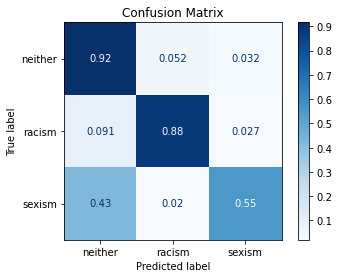

In [47]:
plot_confusion_matrix(cv_gbdt, X_test, y_test, normalize='true', cmap=plt.cm.Blues,
                      display_labels=['neither','racism','sexism'])
plt.title('Confusion Matrix')
#plt.savefig('figure_3.png', dpi=200, transparent=True)
plt.show()

In [142]:
print(classification_report(y_test,y_pred_gbdt))

              precision    recall  f1-score   support

           0       0.63      0.93      0.75      1689
           1       0.97      0.89      0.93      3869
           2       0.85      0.56      0.68      1359

    accuracy                           0.83      6917
   macro avg       0.82      0.79      0.79      6917
weighted avg       0.86      0.83      0.83      6917



## Neural Network method

#### Use pre-trained GloVe

In [182]:
embeddings_index = dict()

# load the whole embedding into memory
f = open('/Volumes/DATA/UNIMI/Text Mining and Sentiment Analysis/Sentiment Analysis/glove.twitter.27B/glove.twitter.27B.200d.txt', encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 1193514 word vectors.


In [183]:
X.shape

(34585,)

In [271]:
X = pd.Series(X).map(lambda x: text_cleaning(x))
X_data = X
y_data = y

In [272]:
len(X)

34585

In [186]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)
sequences = tokenizer.texts_to_sequences(X)
word_index = tokenizer.word_index
X = pad_sequences(sequences, maxlen=120)
y = (np.asarray(y))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [187]:
sequences

[[77, 2, 19, 69, 967, 1124, 286],
 [2, 180, 5, 8488, 12239, 12240, 438, 129, 161, 16, 8489],
 [12241],
 [84, 1812, 89, 9, 1813, 67, 67, 3116, 1514, 3413],
 [35, 520, 41, 116, 28, 520, 6699, 1125, 364, 3],
 [39, 1, 3117, 50],
 [12242, 9, 7, 354, 12243, 152],
 [2660, 4811, 6],
 [1095,
  20,
  3753,
  143,
  531,
  2881,
  1014,
  355,
  66,
  1460,
  289,
  1348,
  12244,
  347,
  8490],
 [8491, 8],
 [2348, 4200, 766, 1397, 4201],
 [2, 5, 87, 12245],
 [],
 [3754, 17, 634, 550, 165, 613, 387],
 [787, 6],
 [27, 540, 9, 127, 221, 540, 9, 127, 418, 1254, 280, 348],
 [31, 914, 5550, 388, 140, 2500, 5, 581, 439],
 [6, 268],
 [257, 1304, 152],
 [191, 569, 12, 5, 8492, 49],
 [2, 12246, 18, 35, 12247, 4, 254, 12248, 1515],
 [3414, 3414, 3, 12249],
 [47, 30, 124, 5551, 1126, 3118],
 [10, 5552, 2, 152, 242, 476, 15],
 [2, 304, 1, 89, 13],
 [39, 73, 108, 570, 60, 48, 724, 163, 60, 1349, 158, 33],
 [238, 94, 20, 3415, 2501, 1127, 3, 477],
 [3119,
  6700,
  1658,
  489,
  2349,
  24,
  521,
  7,
  101

In [188]:
vocab_size = len(tokenizer.word_index) + 1
vocab_size

28218

In [189]:
# create a weight matrix for words in training docs
embedding_matrix = np.zeros((vocab_size, 200))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [190]:
embedding_matrix.shape

(28218, 200)

In [192]:
model_glove = Sequential()
    #if not model_variation=='CNN-rand':
model_glove.add(Embedding(vocab_size, 200, input_length = 120, weights=[embedding_matrix], trainable=False))
model_glove.add(Dropout(0.25))#, input_shape=(sequence_length, embedding_dim)))
model_glove.add(Conv1D(512, activation = 'relu', kernel_size = 2))
model_glove.add(Dropout(0.5))

model_glove.add(Flatten())
model_glove.add(Dense(3))
model_glove.add(Activation('softmax'))
print(model_glove.summary())
model_glove.compile(loss = 'categorical_crossentropy', optimizer = Adam(lr=1e-3), metrics = ['accuracy'])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 120, 200)          5643600   
_________________________________________________________________
dropout_4 (Dropout)          (None, 120, 200)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 119, 512)          205312    
_________________________________________________________________
dropout_5 (Dropout)          (None, 119, 512)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 60928)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 182787    
_________________________________________________________________
activation_2 (Activation)    (None, 3)                

/Users/namnguyen/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [194]:
model_glove.fit(X_train, to_categorical(np.asarray(y_train)), validation_split=0.2, epochs = 20, batch_size = 128)

Train on 22134 samples, validate on 5534 samples
Epoch 1/20
22134/22134 [==============================] - ETA: 0s - loss: 0.5787 - acc: 0.7751

/Users/namnguyen/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:2426: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


22134/22134 [==============================] - 38s 2ms/sample - loss: 0.5787 - acc: 0.7751 - val_loss: 0.4872 - val_acc: 0.8216
Epoch 2/20
22134/22134 [==============================] - 42s 2ms/sample - loss: 0.4552 - acc: 0.8294 - val_loss: 0.4569 - val_acc: 0.8327
Epoch 3/20
22134/22134 [==============================] - 34s 2ms/sample - loss: 0.4038 - acc: 0.8496 - val_loss: 0.4358 - val_acc: 0.8415
Epoch 4/20
22134/22134 [==============================] - 34s 2ms/sample - loss: 0.3742 - acc: 0.8625 - val_loss: 0.4354 - val_acc: 0.8412
Epoch 5/20
22134/22134 [==============================] - 34s 2ms/sample - loss: 0.3440 - acc: 0.8748 - val_loss: 0.4292 - val_acc: 0.8433
Epoch 6/20
22134/22134 [==============================] - 31s 1ms/sample - loss: 0.3255 - acc: 0.8819 - val_loss: 0.4295 - val_acc: 0.8486
Epoch 7/20
22134/22134 [==============================] - 31s 1ms/sample - loss: 0.3033 - acc: 0.8896 - val_loss: 0.4358 - val_acc: 0.8468
Epoch 8/20
22134/22134 [==============

In [195]:
y_pred_glove = model_glove.predict_classes(X_test)

/Users/namnguyen/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [196]:
f1_score(y_test, (y_pred_glove), average = 'weighted')

0.8477910066061454

In [197]:
print(classification_report(y_test,y_pred_glove))

              precision    recall  f1-score   support

           0       0.74      0.80      0.77      1677
           1       0.91      0.94      0.93      3872
           2       0.80      0.66      0.73      1368

    accuracy                           0.85      6917
   macro avg       0.82      0.80      0.81      6917
weighted avg       0.85      0.85      0.85      6917



In [212]:

model_lstm = Sequential()
model_lstm.add(Embedding(vocab_size, 200, weights=[embedding_matrix], input_length = 120, trainable = False))
model_lstm.add(Dropout(0.25))
model_lstm.add(LSTM(80, input_shape=(27668, 120)))
model_lstm.add(Dropout(0.5))
model_lstm.add(Dense(3))
model_lstm.add(Activation('softmax'))
model_lstm.compile(loss='categorical_crossentropy', optimizer = Adam(lr=1e-3), metrics=['accuracy'])

/Users/namnguyen/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [213]:
model_lstm.fit(X_train, to_categorical(np.asarray(y_train)), validation_split=0.2, epochs = 20, batch_size = 128)

Train on 22134 samples, validate on 5534 samples
Epoch 1/20
22134/22134 [==============================] - ETA: 0s - loss: 0.5793 - acc: 0.7649

/Users/namnguyen/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:2426: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


22134/22134 [==============================] - 32s 1ms/sample - loss: 0.5793 - acc: 0.7649 - val_loss: 0.4647 - val_acc: 0.8222
Epoch 2/20
22134/22134 [==============================] - 33s 2ms/sample - loss: 0.4421 - acc: 0.8335 - val_loss: 0.4208 - val_acc: 0.8345
Epoch 3/20
22134/22134 [==============================] - 31s 1ms/sample - loss: 0.4079 - acc: 0.8431 - val_loss: 0.4131 - val_acc: 0.8394
Epoch 4/20
22134/22134 [==============================] - 32s 1ms/sample - loss: 0.3811 - acc: 0.8528 - val_loss: 0.3890 - val_acc: 0.8497
Epoch 5/20
22134/22134 [==============================] - 34s 2ms/sample - loss: 0.3637 - acc: 0.8601 - val_loss: 0.3774 - val_acc: 0.8549
Epoch 6/20
22134/22134 [==============================] - 34s 2ms/sample - loss: 0.3481 - acc: 0.8674 - val_loss: 0.3721 - val_acc: 0.8576
Epoch 7/20
22134/22134 [==============================] - 32s 1ms/sample - loss: 0.3328 - acc: 0.8725 - val_loss: 0.3648 - val_acc: 0.8607
Epoch 8/20
22134/22134 [==============

In [214]:
y_pred_lstm = model_lstm.predict_classes(X_test)

/Users/namnguyen/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [215]:
y_pred_lstm

array([2, 1, 2, ..., 1, 1, 2])

In [216]:
f1_score(y_test, (y_pred_lstm), average = 'weighted')

0.8660820198483651

In [217]:
print(classification_report(y_test,y_pred_lstm))

              precision    recall  f1-score   support

           0       0.76      0.81      0.79      1677
           1       0.93      0.94      0.94      3872
           2       0.81      0.73      0.77      1368

    accuracy                           0.87      6917
   macro avg       0.83      0.83      0.83      6917
weighted avg       0.87      0.87      0.87      6917



Text(0, 0.5, 'Counts')

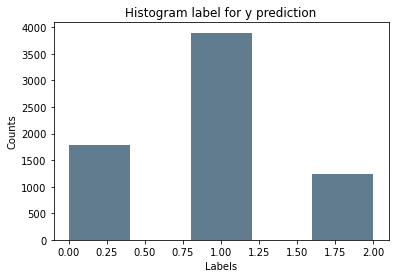

In [229]:
#Plotting histogram of labels to see how they are distributed
pd.Series(y_pred_lstm).plot.hist(bins=5, rwidth=2, color='#607c8e')
plt.title('Histogram label for y prediction')
plt.xlabel('Labels')
plt.ylabel('Counts')

In [285]:
dump(model_lstm, 'lstm_gbdt.pkl')

TypeError: can't pickle _thread.RLock objects

In [219]:
X_train_in = model_lstm.predict(X_train)
X_test_in = model_lstm.predict(X_test)

In [220]:
model_combine = GradientBoostingClassifier(n_estimators=100, learning_rate=0.02, max_depth = 1, random_state=0).fit(X_train_in, y_train)

In [221]:
model_combine_pred = model_combine.predict(X_test_in)

In [222]:
f1_score(y_test, (model_combine_pred), average = 'weighted')

0.8689700366186022

In [223]:
print(classification_report(y_test, model_combine_pred))

              precision    recall  f1-score   support

           0       0.80      0.77      0.79      1677
           1       0.93      0.95      0.94      3872
           2       0.78      0.77      0.78      1368

    accuracy                           0.87      6917
   macro avg       0.84      0.83      0.83      6917
weighted avg       0.87      0.87      0.87      6917



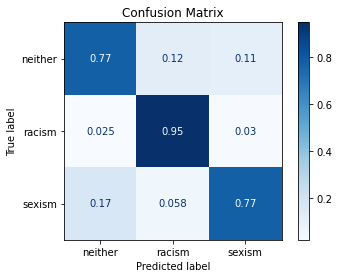

In [231]:
plot_confusion_matrix(model_combine, X_test_in, y_test, normalize='true', cmap=plt.cm.Blues,
                      display_labels=['neither','racism','sexism'])
plt.title('Confusion Matrix')
plt.savefig('model_combine_cm.png', dpi=200, transparent=True)
plt.show()

In [76]:
dump(model_combine, 'lstm_gbdt.pkl')

['lstm_gbdt.pkl']

In [331]:
abc = load('/Volumes/DATA/UNIMI/Text Mining and Sentiment Analysis/hate_speech_detection/gbdt.pkl')

In [332]:
a = pd.Series(text_cleaning("you bitch"))

In [80]:
aa = tokenizer.texts_to_sequences(a)

In [333]:
pred = abc.predict(a)[0]
#l = abc.predict_classes()

NotFittedError: The TF-IDF vectorizer is not fitted

In [82]:
hate_speech[pred]

'racism'

## Most relevant terminology by category

In [273]:
# use tf-idf extraction on the data
vtorizer = TfidfVectorizer()
X_tf = vtorizer.fit_transform(X_data)
features = vtorizer.get_feature_names()

In [274]:
X_tf.shape

(34585, 28166)

In [275]:
X_tf[1].shape

(1, 28166)

In [276]:
def top_tfidf_feats(row, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

In [277]:
def top_mean_feats(Xtr, features, grp_ids=None, min_tfidf=0.1, top_n=25):
    ''' Return the top n features that on average are most important amongst documents in rows
        indentified by indices in grp_ids. '''
    if grp_ids:
        D = Xtr[grp_ids].toarray()
    else:
        D = Xtr.toarray()

    D[D < min_tfidf] = 0
    tfidf_means = np.mean(D, axis=0)
    return top_tfidf_feats(tfidf_means, features, top_n)

In [278]:
def top_feats_by_class(Xtr, y, features, min_tfidf=0.1, top_n=25):
    ''' Return a list of dfs, where each df holds top_n features and their mean tfidf value
        calculated across documents with the same class label. '''
    dfs = []
    labels = np.unique(y)
    for label in labels:
        ids = np.where(y==label)
        feats_df = top_mean_feats(Xtr, features, ids, min_tfidf=min_tfidf, top_n=top_n)
        feats_df.label = label
        dfs.append(feats_df)
    return dfs

In [279]:
print(top_feats_by_class(X_tf, y, features, top_n=5, min_tfidf=0.7))

[  feature     tfidf
0  faggot  0.002844
1     yes  0.002776
2     mkr  0.002102
3     yup  0.001957
4     fag  0.001947,   feature     tfidf
0   bitch  0.006142
1   pussy  0.003179
2     hoe  0.002131
3   loyal  0.001662
4    hoes  0.001469,     feature     tfidf
0     trash  0.003211
1    monkey  0.000900
2  brownies  0.000881
3    ghetto  0.000819
4    yellow  0.000671]


In [280]:
label_dic = {'neither': 0, 'racism': 1, 'sexism': 2}
hate_speech = {
  0: "neither",
  1: "racism",
  2: "sexism"
}

In [281]:
# function to plot the most relevant terms
def terminology(label, n_terms=10, threshold=0.7):
    top_feats_by_class(X_tf, y, features, top_n=n_terms, min_tfidf=threshold)[label_dic[label]]\
    .sort_values(by='tfidf',ascending=True)\
    .plot(kind='barh', x='feature', stacked=True)
    plt.title('Most important terms in the ' + label + ' category')
    plt.xlabel('TF-IDF value')
    plt.ylabel('Term')
    plt.xticks(fontsize=8)
    plt.savefig('figure_' + label + '.png', dpi=200, transparent=True)
    plt.show()

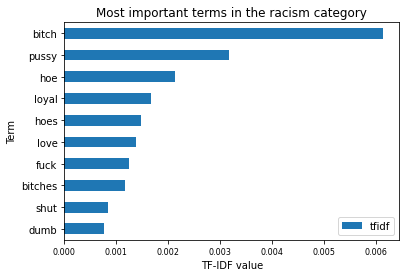

In [282]:
terminology('racism')

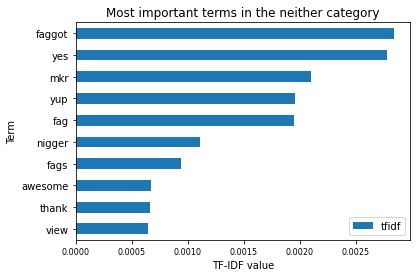

In [283]:
terminology('neither')

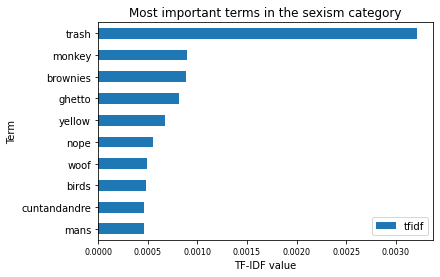

In [284]:
terminology('sexism')